In [338]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import mne
from mne.preprocessing import ICA
import pywt
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram

Preproccesing Functions

In [339]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = custom_detrend(df_new, col_names)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.1  # Make interpolated values 0.1 times smaller
    # Check each interpolated value's difference from median and compare to the threshold
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    df[channel] = interpolated_values
    return df


Define the dataset

In [340]:
folder_name = 'i'
selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
duration = 40 
raw=[]
event=[]
BP=[]
PP=[]
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst = s_temp.iloc[:, 17]
            df_temp = s_temp.iloc[:, :8]
            # print(df_temp.shape)
            # df_temp.plot(figsize=(10, 8))
            # plt.show()
            raw.append(df_temp)
            event.append(inst)
            
            # 1. Band Pass
            raw_bp = np.copy(df_temp)
            for column in range(8):
                raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250) 
            print(raw_bp.shape)
            # plt.plot(raw_bp)
            # plt.show()
            
            # 2. Artifact rejection
            BP_artifact_RJ = np.copy(raw_bp)
            for channel in range (8):
                BP_artifact_RJ= reject_artifacts(pd.DataFrame(BP_artifact_RJ), channel)
            # plt.plot(BP_artifact_RJ)
            # plt.show()
            
            # 3. Smoothing
            BP_artifact_RJ_SM=BP_artifact_RJ.copy()
            window_size = 10 
            for channel in range (8):
                # channel_data = BP_artifact_RJ_SM[channel, :]
                BP_artifact_RJ_SM= BP_artifact_RJ_SM.rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')
            # plt.plot(BP_artifact_RJ_SM)
            # plt.show()
            BP.append(BP_artifact_RJ_SM)
            
            # 4. Denoising and other preprocessing
            BP_artifact_RJ_SM.columns = selected_columns
            eeg_df_denoised = preprocess(pd.DataFrame(BP_artifact_RJ_SM), col_names=selected_columns, n_clusters=[50]*len(selected_columns))
            # eeg_df_denoised.plot(subplots=True, figsize=(15, 10), title='Denoised EEG Data')
            # plt.show()
            PP.append(eeg_df_denoised)

(10000, 8)
(10000, 8)
(10000, 8)
(10000, 8)
(10000, 8)
(10000, 8)
(10000, 8)
(10000, 8)


In [341]:
fs=250
B_N=int(len(PP)) #Number of blocks
PP_NP=np.array(PP) #shape: (B_N, 10000, 8=Channel Numbers)
event=np.array(event).reshape(B_N*(df_temp.shape[0]), 1) # df_temp.shape[0]=10000

denoised=PP_NP.reshape(B_N*(df_temp.shape[0]), 8) # seprate each blocks' signal 
pp_sig_event=np.concatenate((denoised, event), axis=1) 

labels=[] 
face = [] #lable=0
scene=[]#lable=1
# Aassuming correctness for the human behavior
for i in range(len(pp_sig_event)): #len(pp_sig_event) = the whole sample points, (df_temp.shape[0]*B_N)
    if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
        face.append(pp_sig_event[i])
        labels.append(0)
    else:
        scene.append(pp_sig_event[i]) 
        labels.append(1)        
face = np.array(face)
scene = np.array(scene)
labels=np.array(labels) 
                 
print('event', event.shape,  'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)   

event (80000, 1) denoised (80000, 8) pp_sig_event (80000, 9) face (40000, 9) scene (40000, 9) labels (80000,)


denoised is all the denoised data with shape: (df_temp.shape[0]*B_N, 8)                                                                                                                

event is all the events with shape: (df_temp.shape[0]*B_N, 1)

In [342]:
#Wavelet
denoised_reshaped = denoised.reshape(int(denoised.shape[0]/250), 250, 8)
# Apply wavelet transform and extract features
features_wavelet = []
for segment in denoised_reshaped:
    segment_features = []
    for channel_data in segment.T:  # Going through each channel
        coeffs = pywt.wavedec(channel_data, 'db4', level=4)
        for coeff in coeffs:
            segment_features.extend([np.mean(coeff), np.var(coeff), 
                                     skew(coeff), kurtosis(coeff)])
    features_wavelet.append(segment_features)
features_wavelet_np = np.array(features_wavelet)
wavelet_np=features_wavelet_np.reshape(features_wavelet_np.shape[0], 8, int(features_wavelet_np.shape[1]/8))
# wavelet_np.shape : (320, 8, 20)
# Now, given 8 channels, the number of features per segment for each channel would be:
# 5 coefficients * 4 statistics = 20 features.
# For 8 channels, you'd have:
# 8 channels * 20 features/channel = 160 features.

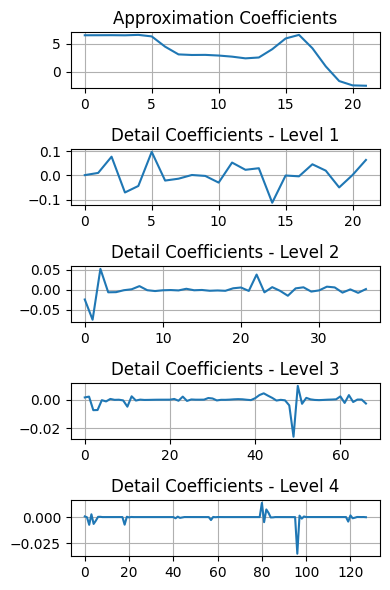

In [344]:
# Choose a segment and channel
segment_idx = 1
channel_idx = 7
segment = denoised_reshaped[segment_idx, :, channel_idx]
# Perform wavelet decomposition
coeffs = pywt.wavedec(segment, 'db4', level=4)
# Plotting
plt.figure(figsize=(4, 6))
for i, coeff in enumerate(coeffs):
    ax = plt.subplot(len(coeffs), 1, i + 1)
    ax.plot(coeff)
    if i == 0:
        ax.set_title('Approximation Coefficients')
    else:
        ax.set_title(f'Detail Coefficients - Level {i}')
    ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
F_N=int(B_N/2)
S_N=int(B_N/2)
face_eeg_dada=face.reshape(F_N,int(df_temp.shape[0]/fs),250,9)
face_eeg_dada=face_eeg_dada[:,:,:,:8]
print(face_eeg_dada.shape)
# face_eeg_dada=face_eeg_dada.mean(axis=3)
face_eeg_dada=face_eeg_dada.mean(axis=1)
print(face_eeg_dada.shape)
face_mean=face_eeg_dada.mean(axis=0)
print(face_mean.shape)
scene_eeg_dada=scene.reshape(S_N,int(df_temp.shape[0]/fs),250,9)
scene_eeg_dada=scene_eeg_dada[:,:,:,:8]
# scene_eeg_dada=scene_eeg_dada.mean(axis=3)
scene_eeg_dada=scene_eeg_dada.mean(axis=1)
print(scene_eeg_dada.shape)
scene_mean=scene_eeg_dada.mean(axis=0)
print(scene_mean.shape, type(scene_mean))

In [8]:
# The parameter nperseg is crucial because it directly affects the time-frequency resolution of the spectrogram:
# Time Resolution: The length of each segment in time is nperseg/sampling_rate. So if nperseg is large, 
# you'll get better frequency resolution (because you're taking an FFT of a longer segment) 
# but worse time resolution (because each segment, and thus each column of the spectrogram, spans a longer period of time).
# Frequency Resolution: The frequency resolution (i.e., the distance between discrete frequency bins) is sampling_rate/nperseg. 
# So a larger nperseg provides a finer frequency resolution.  
# If nperseg=50 and fs=250 (sampling rate of 250 Hz):
# Each segment (time bin) of the spectrogram would represent 50/250 = 0.2 seconds (or 200 milliseconds).
# The frequency resolution would be 250/50 = 5 Hz, meaning each frequency bin represents a bandwidth of 5 Hz.


In [ ]:
def plot_spectrogram(signal, channel_idx=0, fs=250, nperseg=50):
    signal = np.real(signal)  # Ensure the signal is real
    channel_data = signal[:, channel_idx]
    f, t, Sxx = spectrogram(channel_data, fs=fs, nperseg=nperseg)
    # Compute magnitude of Sxx and convert to float
    Sxx_magnitude = np.abs(Sxx).astype(float)
    # Compute the log10 for each element
    Sxx_dB = 10 * np.array([[np.log10(val + 1e-10) for val in row] for row in Sxx_magnitude])
    return f, t, Sxx_dB

def draw_spectrogram(ax, f, t, Sxx_dB, title, vmin, vmax):
    cax = ax.pcolormesh(t, f, Sxx_dB, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    ax.set_title(title)
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [s]')
    return cax
for j in range(8):  # Assuming you have 8 channels
    # Compute the spectrogram for each channel and determine the min and max values for the current channel
    _, _, scene_dB = plot_spectrogram(scene_mean, j)
    _, _, face_dB = plot_spectrogram(face_mean, j)
    vmin = min(scene_dB.min(), face_dB.min())
    vmax = max(scene_dB.max(), face_dB.max())
    # Create figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
    # Plot the spectrograms for the current channel
    f, t, scene_dB = plot_spectrogram(scene_mean, channel_idx=j)
    im1 = draw_spectrogram(axs[0], f, t, scene_dB, f'Spectrogram - Scene (Channel {j})', vmin, vmax)
    f, t, face_dB = plot_spectrogram(face_mean, channel_idx=j)
    im2 = draw_spectrogram(axs[1], f, t, face_dB, f'Spectrogram - Face (Channel {j})', vmin, vmax)
    # Adjust layout and add colorbar
    fig.colorbar(im1, ax=axs[1], orientation='vertical', label='Intensity [dB]')
    fig.colorbar(im1, ax=axs[0], orientation='vertical', label='Intensity [dB]')
    plt.tight_layout()
    plt.show()


In [85]:
# def compute_spectrogram(signal, channel_idx=0):
#     """Computes the spectrogram of the given signal for a specific channel."""
    
#     # Extracting the data for the specified channel
#     channel_data = signal[:, channel_idx]
    
#     # Calculate the spectrogram
#     f, t, Sxx = spectrogram(channel_data, fs=fs, nperseg=50)
    
#     # Convert power (Sxx) to dB scale
#     if np.any(np.iscomplex(Sxx)):
#         Sxx = np.abs(Sxx)  # Convert complex values to magnitude (just in case)
#     Sxx_dB = 10 * np.log10(Sxx + 1e-10)  # Added a small constant to avoid log(0)
    
#     return f, t, Sxx_dB


In [ ]:
F_N=int(B_N/2)
S_N=int(B_N/2)
face_eeg_dada=face.reshape(F_N,int(df_temp.shape[0]/fs),50,5,9)
face_eeg_dada=face_eeg_dada[:,:,:,:,:8]
face_eeg_dada=face_eeg_dada.mean(axis=3)
face_eeg_dada=face_eeg_dada.mean(axis=1)
print(face_eeg_dada.shape)
face_mean=face_eeg_dada.mean(axis=0)
print(face_mean.shape)
scene_eeg_dada=scene.reshape(S_N,int(df_temp.shape[0]/fs),50,5,9)
scene_eeg_dada=scene_eeg_dada[:,:,:,:,:8]
scene_eeg_dada=scene_eeg_dada.mean(axis=3)
scene_eeg_dada=scene_eeg_dada.mean(axis=1)
print(scene_eeg_dada.shape)
scene_mean=scene_eeg_dada.mean(axis=0)
print(scene_mean.shape, type(scene_mean))

time_list=[]
for n in range(face_mean.shape[0]):
    time = (n*5)/(fs)*1000
    time_list.append(time)
plt.figure(figsize=(16,16))
for channel in range(8):
    plt.subplot(4,4, channel + 1)  
    plt.plot(time_list, face_mean[:, channel], label=f'Scene')
    plt.plot(time_list, scene_mean[:, channel], label=f'Face')
    plt.legend()
plt.tight_layout()
plt.show()      

ERP Feature Extraction

In [171]:
c=(50/1000)
N180_window = (int(160*c),int(200*c))
P300_window = (int(280*c),int(320*c)) 
N500_window = (int(480*c), int(520*c))
N600_window = (int(580*c), int(620*c))
P700_window = (int(680*c),int(720*c))
P900_window = (int(880*c),int(920*c))

def extract_ERP_features(epoch):
    
    N180_region= epoch[N180_window[0]:N180_window[1]]
    P300_region = epoch[P300_window[0]:P300_window[1]]
    N500_region = epoch[N500_window[0]:N500_window[1]]
    N600_region = epoch[N600_window[0]:N600_window[1]]
    P700_region = epoch[P700_window[0]:P700_window[1]]
    P900_region = epoch[P900_window[0]:P900_window[1]]

    N180_amplitude= np.min(N180_region)
    N180_mean_amplitude = np.mean(N180_region)
    N180_latency = np.argmax(N180_region) + N180_window[0]
    
    P300_amplitude = np.max(P300_region)
    P300_mean_amplitude = np.mean(P300_region)
    P300_latency = np.argmax(P300_region) + P300_window[0]
    
    N500_amplitude = np.min(N500_region)
    N500_mean_amplitude = np.mean(N500_region)
    N500_latency = np.argmin(N500_region) + N500_window[0]
    
    N600_amplitude = np.min(N600_region)
    N600_mean_amplitude = np.mean(N600_region)
    N600_latency = np.argmin(N600_region) + N600_window[0]

    P700_amplitude = np.max(P700_region)
    P700_mean_amplitude = np.mean(P700_region)
    P700_latency = np.argmax(P700_region) + P700_window[0]
    
    P900_amplitude = np.max(P900_region)
    P900_mean_amplitude = np.mean(P900_region)
    P900_latency = np.argmin(P900_region) + P900_window[0]

    return [
        N180_mean_amplitude, 
        P300_mean_amplitude, 
        N500_mean_amplitude, 
        N600_mean_amplitude, 
        P700_mean_amplitude, 
        P900_mean_amplitude, 
    ]

frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40),
     }


# 'ERP':(0.4,40)
def apply_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def extract_ERP_for_band(signal, band_limits, fs=250):
    band_filtered_signal = apply_bandpass_filter(signal, band_limits[0], band_limits[1], fs)
    return extract_ERP_features(band_filtered_signal)

def extract_all_band_ERPs(signal, frequency_bands):
    all_band_features = {}
    for band_name, band_limits in frequency_bands.items():
        all_band_features[band_name] = extract_ERP_for_band(signal, band_limits)
    return all_band_features

def extract_all_band_ERPs_to_array(signal, frequency_bands):
    all_band_features_list = []
    for band_name, band_limits in frequency_bands.items():
        erp_features_for_band = extract_ERP_for_band(signal, band_limits)
        all_band_features_list.extend(erp_features_for_band)
    return np.array(all_band_features_list)

def calculate_hilbert_features(signal, fs):
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

In [350]:
X=denoised.reshape(int(denoised.shape[0]/fs), fs*8)
label=labels.reshape(int(labels.shape[0]/fs), fs)
Y=np.squeeze(label[:,0])
data = X

Feature Extraction

In [351]:


BP_Power_FE = []
Hil_FE=[]
for i in range(data.shape[0]):
    eeg_signal = data[i, :].reshape(8, 250)  # reshaped to (8, 250)
    Power_feature_for_sample = []
    Hil_feature_for_sample = []
    for channel in range(8):
        channel_signal = eeg_signal[channel, :]
        power_for_channel = []
        hilbert_for_channel=[]
        for band, (low, high) in frequency_bands.items():
            filtered_signal = apply_bandpass_filter(channel_signal, low, high, fs)
            mean_amplitude = np.mean((filtered_signal)**2)
            hill=np.mean(calculate_hilbert_features(filtered_signal, fs))
            power_for_channel.append(mean_amplitude)
            hilbert_for_channel.append(hill)
        Power_feature_for_sample.append(power_for_channel)
        Hil_feature_for_sample.append(hilbert_for_channel) 
    BP_Power_FE.append(Power_feature_for_sample)
    Hil_FE.append(Hil_feature_for_sample)
BP_Power_FE_np = np.array(BP_Power_FE)
Hil_FE_np=np.array(Hil_FE)
print(BP_Power_FE_np.shape) 
print(Hil_FE_np.shape)

data_reshaped = X.reshape(int(denoised.shape[0]/fs), 8, 250)
ERP_FE = np.array([[extract_ERP_features(data_reshaped[i, j, :]) for j in range(8)] for i in range(int(denoised.shape[0]/fs))])
print(ERP_FE.shape)


(320, 8, 5)
(320, 8, 5)
(320, 8, 6)


In [352]:
combined_features = np.concatenate([wavelet_np], axis=2)
print(combined_features.shape)  # Should print (1600, 8, 11)

(320, 8, 20)


In [353]:
combined_features.shape[0]

320

In [354]:
af=combined_features.reshape(int(combined_features.shape[0]), int(8*combined_features.shape[2]))


In [355]:
af, Y = shuffle(af, Y)
print(af.shape, Y.shape)

(320, 160) (320,)


In [356]:


# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(af, Y)
X_resampled= X_resampled.astype(np.float32)
y_resampled = y_resampled.astype(np.int32)

# Split X and y into training and testing sets
# X_touched, X_untouch, y_touch, y_untouch = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.1, random_state=42)

# Convert y_train and y_test to categorical format for Keras
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
# y_untouch=tf.keras.utils.to_categorical(y_untouch, num_classes=2)


# Convert the data to a numerical type (float)
X_train = X_train.astype(np.float64)
print(X_train.shape)

# Convert one-hot-encoded labels to integer-encoded labels
y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)
# y_untouch = np.argmax(y_untouch, axis=-1)
print(y_train.shape, y_test.shape)


print('X_train:', X_train.shape, 'y_train:', y_train.shape, 'X_test:', X_test.shape, 'y_test:',
      y_test.shape, 'X_untouch:', 'y_untouch:' )

(288, 160)
(288,) (32,)
X_train: (288, 160) y_train: (288,) X_test: (32, 160) y_test: (32,) X_untouch: y_untouch:


In [359]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict class labels for the test set
y_pred = clf.predict(X_test)

# Generate and print classification report
report = classification_report(y_test, y_pred)
print(report)

# Print accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.68      0.65      0.67        20
           1       0.46      0.50      0.48        12

    accuracy                           0.59        32
   macro avg       0.57      0.57      0.57        32
weighted avg       0.60      0.59      0.60        32

Accuracy: 0.59375


In [360]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define the objective function
def objective(trial):
    # Define search space
    n_estimators = trial.suggest_int('n_estimators', 100, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        criterion=criterion
    )

    # Use StratifiedKFold cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    return cross_val_score(clf, X_train, y_train, cv=stratified_kfold, n_jobs=-1).mean()

# Create a study object and specify the direction is maximize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Best hyperparameters
print(study.best_trial.params)




[I 2023-10-09 15:39:32,037] A new study created in memory with name: no-name-1253fd79-0a17-4770-9c4a-a1b057df8fc3
[I 2023-10-09 15:39:32,253] Trial 0 finished with value: 0.5661826981246219 and parameters: {'n_estimators': 130, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.5661826981246219.
[I 2023-10-09 15:39:32,442] Trial 1 finished with value: 0.5489413188142771 and parameters: {'n_estimators': 125, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.5661826981246219.
[I 2023-10-09 15:39:32,646] Trial 2 finished with value: 0.5592256503327283 and parameters: {'n_estimators': 115, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'auto', 'criterion': 'entropy'}. Best is trial 0 with value: 0.5661826981246219.
[I 2023-10-09 15:39:32,871] Trial 3 finished with value: 0.5556563823351484 and parameters: {'n_estimators': 116

{'n_estimators': 106, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'gini'}


In [361]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Splitting the data
# X_train_split, X_val, y_train_split, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42)

# Use best hyperparameters from the Optuna optimization (replace these with actual best params)
best_params = study.best_trial.params

clf_best = RandomForestClassifier(**best_params, random_state=42)
clf_best.fit(X_train, y_train)

# Predict on the validation set
y_pred = clf_best.predict(X_test)

# Generate and print classification report
report = classification_report(y_test, y_pred)
print(report)

# Print accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.55      0.67        20
           1       0.53      0.83      0.65        12

    accuracy                           0.66        32
   macro avg       0.69      0.69      0.66        32
weighted avg       0.73      0.66      0.66        32

Accuracy: 0.65625


In [157]:
from sklearn import svm
from joblib import dump
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
# Create a linear SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)
# Save the model to disk
filename = 'C:/Users/tnlab/OneDrive/Documents/GitHub/Neurofeedback-Based-BCI/SVM for Unicorn Data/my_svm_model.joblib'
dump(clf, filename)

# Make predictions on the test set
y_pred = clf.predict(X_test)

print('Model accuracy: ', accuracy_score(y_test, y_pred))
report_svm_matrix = classification_report(y_test, y_pred)
print("Classification Report:")
print(report_svm_matrix)
report_svm = classification_report(y_test, y_pred, output_dict=True)

report_df_svm = pd.DataFrame(report_svm).transpose()
report_df_svm.to_excel(f"svm_classification_report_{folder_name}.xlsx", index=True)

Model accuracy:  0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.20      0.20        10
           1       0.64      0.64      0.64        22

    accuracy                           0.50        32
   macro avg       0.42      0.42      0.42        32
weighted avg       0.50      0.50      0.50        32

